In [2]:
## Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## Vision Stuff
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torchvision
from PIL import Image

## Other libs
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [3]:
import dppy

In [4]:
# Load PyTorch assets

# Load the pretrained model - Resnet 18
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Transforms
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/rsilvei/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [02:29<00:00, 314kB/s] 
/Users/rsilvei/Envs/nlp_new/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [11]:
!ls -lah ../../ipsis_consulting/recommender_system/

total 1568
drwxr-xr-x  10 rsilvei  ADESI\Domain Users   320B Sep 18 11:25 .
drwxr-xr-x   6 rsilvei  ADESI\Domain Users   192B Apr  2 09:32 ..
-rw-r--r--@  1 rsilvei  ADESI\Domain Users   6.0K Apr 22 18:11 .DS_Store
drwxr-xr-x   6 rsilvei  ADESI\Domain Users   192B Jun 10 10:37 .ipynb_checkpoints
-rw-r--r--   1 rsilvei  ADESI\Domain Users    42K Apr 23 11:29 1-Copy1.dataset_exploration.ipynb
-rw-r--r--   1 rsilvei  ADESI\Domain Users    73K Jun 10 10:47 1.dataset_exploration.ipynb
-rw-r--r--   1 rsilvei  ADESI\Domain Users   628K Sep 18 11:25 2.resnet50_pytorch.ipynb
-rw-r--r--   1 rsilvei  ADESI\Domain Users    25K Jun 18 08:47 3.text_query_recommend.ipynb
drwx------@ 10 rsilvei  ADESI\Domain Users   320B Jun 10 14:18 data
drwxr-xr-x   4 rsilvei  ADESI\Domain Users   128B Apr 23 10:41 imgs


In [25]:
img_path = '../../ipsis_consulting/recommender_system/imgs/femme_accessoire_luxe/'

In [26]:
!ls -lah '../../ipsis_consulting/recommender_system/imgs/femme_accessoire_luxe/'

total 132728
drwxr-xr-x  1214 rsilvei  ADESI\Domain Users    38K Apr 22 21:02 .
drwxr-xr-x     4 rsilvei  ADESI\Domain Users   128B Apr 23 10:41 ..
-rw-r--r--@    1 rsilvei  ADESI\Domain Users   6.0K Apr 22 20:36 .DS_Store
-rw-r--r--     1 rsilvei  ADESI\Domain Users    29K Jun 10 10:27 000000.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    18K Jun 10 10:27 000001.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    22K Jun 10 10:27 0000010.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    40K Jun 10 10:31 00000100.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    14K Apr 22 20:56 000001000.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    17K Apr 22 20:56 000001001.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    17K Apr 22 20:56 000001002.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    56K Apr 22 20:56 000001003.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users   139K Apr 22 20:56 000001004.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users   133K Apr 22 20:56 000001005.

-rw-r--r--     1 rsilvei  ADESI\Domain Users   148K Apr 22 20:54 00000931.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    76K Apr 22 20:54 00000932.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    38K Apr 22 20:54 00000933.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    57K Apr 22 20:54 00000934.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    10K Apr 22 20:54 00000935.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users   114K Apr 22 20:54 00000936.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    13K Apr 22 20:54 00000937.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    13K Apr 22 20:54 00000938.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    12K Apr 22 20:54 00000939.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    39K Jun 10 10:30 0000094.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    16K Apr 22 20:54 00000940.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users    30K Apr 22 20:54 00000941.jpg
-rw-r--r--     1 rsilvei  ADESI\Domain Users   114K Apr 22 20:54 

In [29]:
def get_img(img_num):
    print(img_path)
    query_img = img_path + "00000{}.jpg".format(img_num)
    print(query_img)
    img = Image.open(query_img)
    return scaler(img)

In [30]:
def get_embedding(img_num):
    query_img = img_path + "00000{}.jpg".format(img_num)
    img = Image.open(query_img)
    t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
    embedding = model(t_img)
    return embedding.squeeze(0)

../../ipsis_consulting/recommender_system/imgs/femme_accessoire_luxe/
../../ipsis_consulting/recommender_system/imgs/femme_accessoire_luxe/000001.jpg


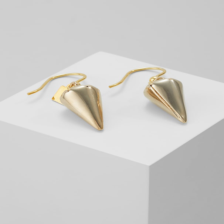

In [31]:
get_img(1)

In [34]:
get_embedding(1)

tensor([-1.9700e+00, -2.4965e+00, -3.1658e+00, -1.3222e+00, -2.7007e-01,
         1.8353e+00,  7.7340e-01, -3.5957e-01, -2.0642e+00, -2.3738e+00,
         1.9827e+00,  6.6168e-01,  1.0978e+00, -2.3780e+00,  1.6038e-01,
        -1.8273e+00, -1.6388e+00, -1.4054e+00, -3.0143e+00, -7.3517e-01,
        -3.4341e+00, -1.4231e+00, -1.6365e+00, -1.0619e+00, -2.3655e+00,
        -4.2973e+00, -2.2920e+00, -1.4958e+00, -3.7795e+00, -3.6033e+00,
         8.1530e-01,  2.1022e-01,  1.3813e+00, -2.0945e+00, -1.3379e+00,
        -2.8592e+00,  6.0286e-01, -7.7108e-01,  2.3782e-01, -1.0176e+00,
         1.6856e+00,  4.6116e-01, -1.2198e+00,  1.6426e+00, -9.4776e-02,
        -3.5610e+00,  1.3276e+00, -4.8298e-01, -4.6783e+00, -3.7944e+00,
        -2.7175e+00, -3.9107e-01, -3.7497e-01, -1.9106e+00, -1.4627e+00,
        -1.4980e+00, -2.7579e+00, -2.0189e+00, -2.1977e+00,  2.1150e+00,
        -2.0320e+00, -3.1366e+00, -3.1903e+00, -1.6683e+00, -1.4872e+00,
        -2.6366e+00, -2.3922e+00, -3.6215e+00, -3.1